# The task

After asking around for the source of the existing data, you learn that the current process is to take a monthly snapshot of prices from a market data provider, which represents the market price of natural gas delivered at the end of each calendar month. This data is available for roughly the next 18 months and is combined with historical prices in a time series database. After gaining access, you are able to download the data in a CSV file: https://cdn.theforage.com/vinternships/companyassets/Sj7temL583QAYpHXD/JiwEkbBq8pFwMRYLc/1683142174343/Nat_Gas.csv

You should use this monthly snapshot to produce a varying picture of the existing price data, as well as an extrapolation for an extra year, in case the client needs an indicative price for a longer-term storage contract.

- Download the monthly natural gas price data.
- Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
- Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future. 
- Your code should take a date as input and return a price estimate.

Try to visualize the data to find patterns and consider what factors might cause the price of natural gas to vary. This can include looking at months of the year for seasonal trends that affect the prices, but market holidays, weekends, and bank holidays need not be accounted for.

# Data exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
price = pd.read_csv("./Nat_Gas.csv")
print(price.shape)
print(price.head())
print(price.tail())

(48, 2)
      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9
      Dates  Prices
43  5/31/24    11.4
44  6/30/24    11.5
45  7/31/24    11.6
46  8/31/24    11.5
47  9/30/24    11.8


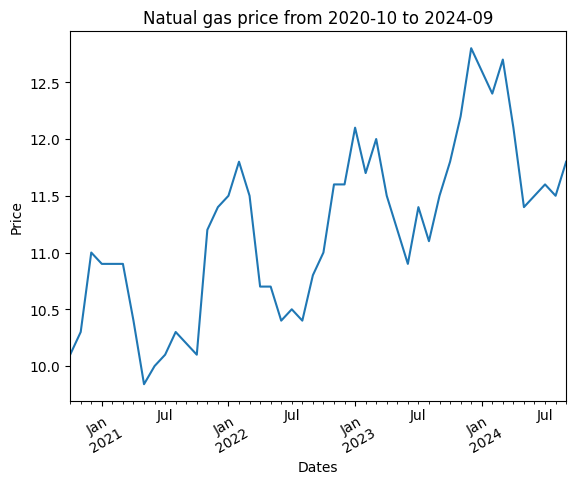

In [3]:
price['Dates'] = pd.to_datetime(price['Dates'], format="%m/%d/%y")
price = price.set_index("Dates")
price.Prices.plot()
plt.xticks(rotation=30)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('Natual gas price from 2020-10 to 2024-09')
plt.show()

The plot above shows this is a typical time series with a clear up-tread and seasonality with a period of 12 months. The price is always the highest in Jauary of each year and the lowest around July of each year. This is probably due to the fact that in winter of the northern hemisphere, the demand of natural gas is higher than that in summer. The price also increases with time probably because of inflation. Let's decompose it and check its trend, seaonality and residual components.

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

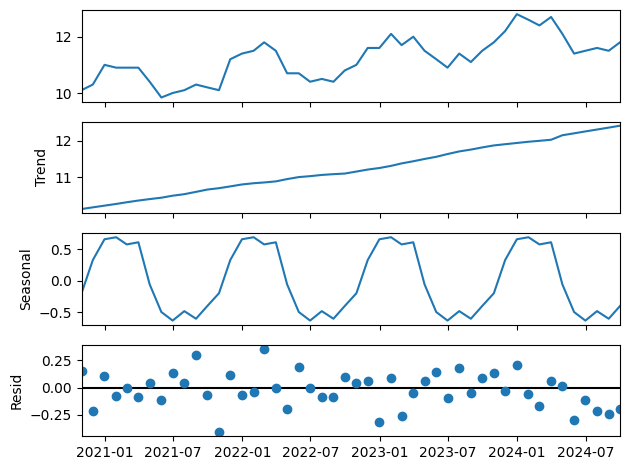

In [5]:
result = seasonal_decompose(price, model='additive', extrapolate_trend='freq')
result.plot()
plt.show()

In [6]:
# check whether the residual is stationary
adfuller(result.resid, autolag='AIC')

(-7.504140644901615,
 4.177707913978499e-11,
 0,
 47,
 {'1%': -3.5778480370438146,
  '5%': -2.925338105429433,
  '10%': -2.6007735310095064},
 -25.5577890967011)

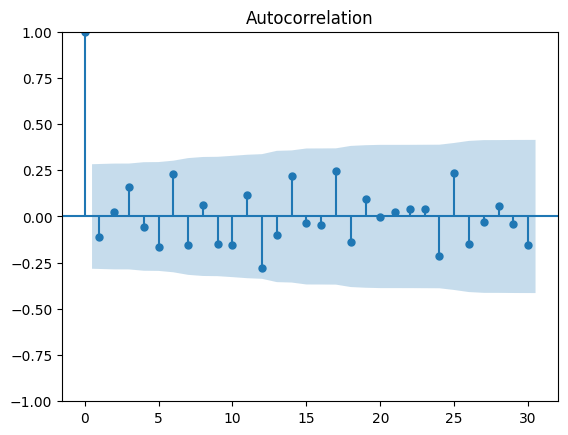

In [7]:
# check whether the residual has any autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(result.resid, lags=30)
plt.show()

The analysis above shows that the time series has an linear trend, sine-wave-like seasonality, and white-noise-like residual. We have three options here: (1) create a model for the trend and seasonality components and add them up to construct the model for the original time series. (2) use the package statsmodels' SARIMA model to account for trend, seasonality, autoaggressive, integration and moving average processes. (3) use the package Prophet. I will go through them one by one.

# Model creation for trend and seasonality

Let's consider option (1) first. The task wants us to perform prediction at daily level, but the data is at the monthly level. So we need to calculate the number of days of each date in the dataset from the first date and use that as the predictor of the model.

## Linear regression for the trend

In [8]:
from sklearn.linear_model import LinearRegression
# train test split function
def train_test_split(df, test_size):
    return df[0:-test_size], df[-test_size:]

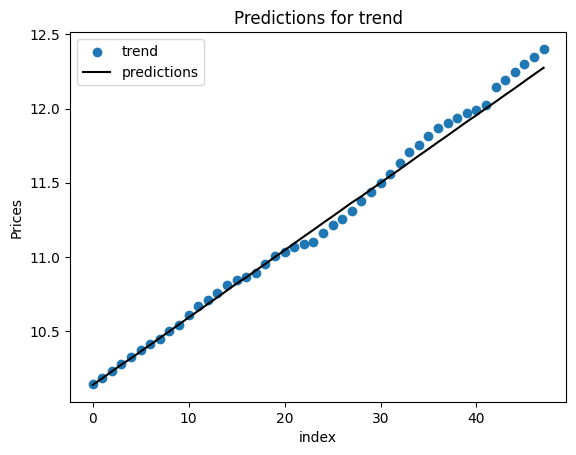

In [9]:
df_trend = pd.DataFrame(result.trend)
df_trend.rename(columns={'trend': 'Prices'}, inplace=True)

# use the number of days from the first date in the data as predictor
df_trend['n_days'] = [(d - df_trend.index[0]).days for d in df_trend.index]

# train test split
train_trend, test_trend = train_test_split(df_trend, 12)
X_train_trend = train_trend['n_days'].values.reshape(-1, 1)
y_train_trend = train_trend['Prices'].values.reshape(-1, 1)

# linear regression
model_trend = LinearRegression()
model_trend.fit(X_train_trend, y_train_trend)

# predictions
predictions_trend = model_trend.predict(df_trend['n_days'].values.reshape(-1, 1)).reshape(48)
plt.scatter(df_trend.reset_index().index, df_trend['Prices'].values, label='trend')
plt.plot(predictions_trend, label='predictions', color='black')
plt.legend()
plt.xlabel('index')
plt.ylabel('Prices')
plt.title('Predictions for trend')
plt.show()

## Sine wave modelling for the seasonality

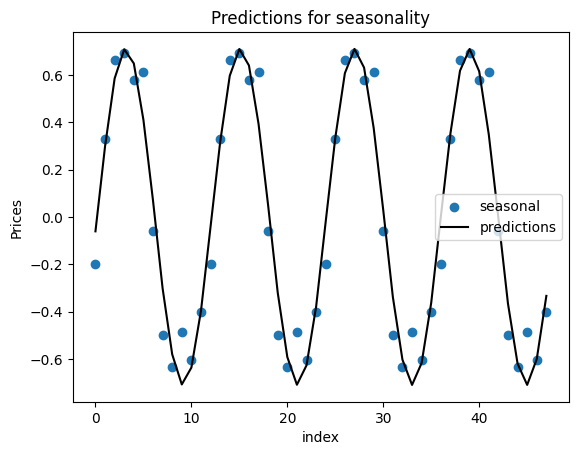

In [10]:
df_seasonal = pd.DataFrame(result.seasonal)
df_seasonal.rename(columns={'seasonal': 'Prices'}, inplace=True)

# use the number of days from the first date in the data as predictor
df_seasonal['n_days'] = [(d - df_seasonal.index[0]).days for d in df_seasonal.index]

# train test split
train_seasonal, test_seasonal = train_test_split(df_seasonal, 12)
X_train_seasonal = train_seasonal['n_days'].values
y_train_seasonal = train_seasonal['Prices'].values

# nonlinear model fit using the sine function
import numpy as np
from scipy.optimize import curve_fit
def model_seasonal(x, a, b, c):
    return a * np.sin(b * x + c)

# the initial guessing of the parameters p0 is important
params, _ = curve_fit(model_seasonal, X_train_seasonal, y_train_seasonal, p0=[0.5, 2*np.pi/365, 0])
predictions_seasonal = model_seasonal(df_seasonal.n_days.values, params[0], params[1], params[2])
plt.scatter(df_seasonal.reset_index().index, df_seasonal.Prices.values, label='seasonal')
plt.plot(predictions_seasonal, label='predictions', color='black')
plt.legend()
plt.xlabel('index')
plt.ylabel('Prices')
plt.title('Predictions for seasonality')
plt.show()

## Model validation

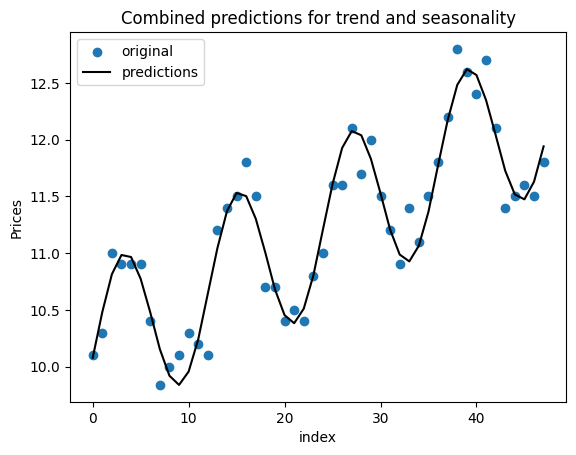

In [11]:
# add two models' prediction together
predictions = predictions_trend + predictions_seasonal

# plot the predictions and original data together
plt.scatter(price.reset_index().index, price.Prices, label='original')
plt.plot(predictions, label='predictions', color='black')
plt.legend()
plt.xlabel('index')
plt.ylabel('Prices')
plt.title('Combined predictions for trend and seasonality')
plt.show()

In [12]:
# calculate the root mean squared error for test set
from sklearn.metrics import mean_squared_error
def measure_rmse(actual, predicted):
    return round((mean_squared_error(actual, predicted))**0.5, 3)
measure_rmse(price.Prices.values[36:48], predictions[36:48])

0.186

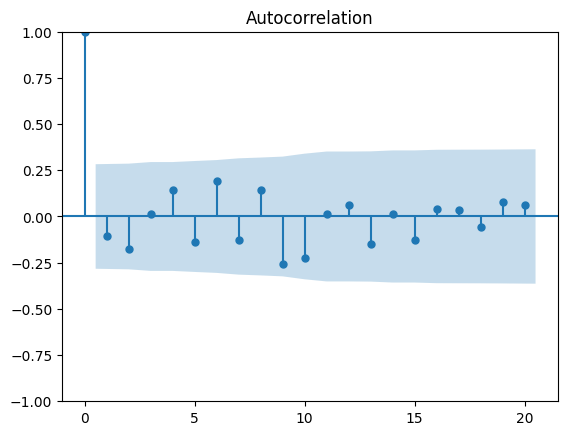

In [13]:
# check the residuals autocorrelation
residuals = price.Prices.values - predictions
plot_acf(residuals, lags=20)
plt.show()

## Estimation for any date

The model validation shows that the model works well. Next I can use the model to estimate the natural gas price for any date since the first date in the dataset. I will perform extrapolation one year into the future.

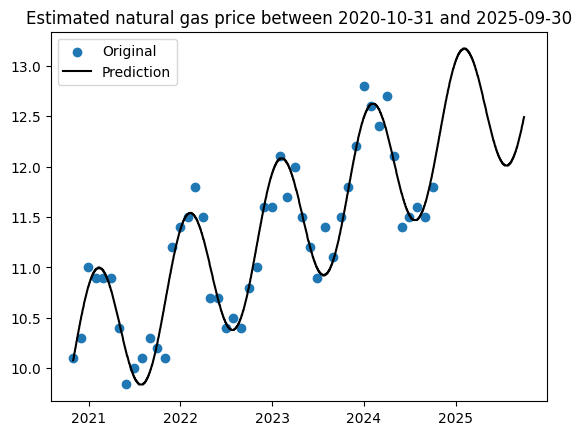

In [14]:
# create all the dates and n_days from the first date in the dataset

from datetime import datetime
from dateutil.relativedelta import relativedelta
n_days_range = (datetime(2025, 9, 30) - price.index[0]).days
Dates = [price.index[0] + relativedelta(days=i) for i in range(n_days_range)]
n_days = np.array([n for n in range(n_days_range)])

# Combine the models for trend and seasonality
def model_fit(n_days):
    return model_trend.predict(n_days.reshape(-1, 1)).reshape(len(n_days)) + \
            model_seasonal(n_days, params[0], params[1], params[2])
Prices = [round(i, 2) for i in model_fit(n_days)]
df_predictions = pd.DataFrame({'n_days': n_days, 'Predictions': Prices}, index=Dates)

# Plot the original and estimated prices together
plt.scatter(x=price.index, y=price.Prices, label='Original')
plt.plot(df_predictions.Predictions, color='black', label='Prediction')
plt.legend()
plt.title('Estimated natural gas price between 2020-10-31 and 2025-09-30')
plt.show()

# SARIMAX model

Next I will try to use the SARIMAX model in the statmodels package. This model has a lot of hyper parameters. Three of them are important. (1) The parameter order in the format of (p,d,q) counts for the normal ARIMA model orders, with p for the number of AR parameters, d for differences, and q for MA parameters. (2) The parameter seasonal_order in the format of (P,D,Q,s) counts for the seasonal ARIMA model orders, with P for the number of AR parameters, D for differences, Q for MA parameters, and s for the period of the seasonality. (3) The parameter trend controls the deterministic trend polynomial. It can be specified as a string where 'c' indicates a constant (i.e. a degree zero component of the trend polynomial), 't' indicates a linear trend with time, 'ct' is both, and 'n' means no trend. Ideally we should set up a grid search to find the best parameters that give the least error. The SARIMAX has 8 important parameters and so the searching space can be very big if we don't have any intuition about what the parameters might be. For example, if we try only 2 values for each of the 8 parameters, we will have 2^8=256 combinations. Here my approach is to do some autocorrelation and partical autocorrelation plots on the original data and have a guess on those parameters based on the plots and the decompostion above.

Even though the Box–Jenkins method (https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method) requires the time series to be stationary, the autocorrelation and partial autocorrelation plots can still show us some clues about the seasonality, the orders of differences, autogressive and moving average processes of the series.

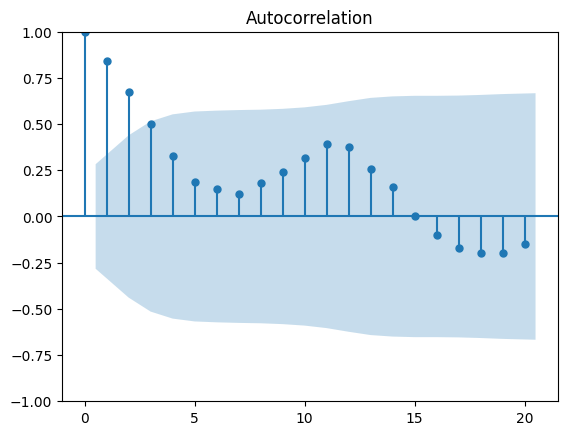

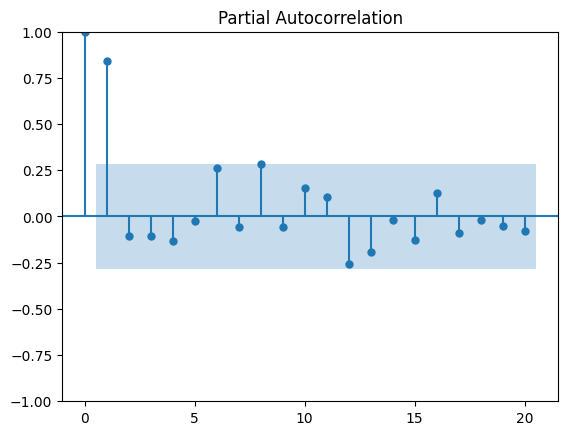

In [15]:
# autocorrelation and partial autocorrelation plots for the original data
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(price.Prices, lags=20)
plot_pacf(price.Prices, lags=20)
plt.show()

The autocorrelation plot above and the seaonal plot in the decomposition clear show the seasonality with a period of 12. The combination of the autocorrelation and partial autocorrelation plots tell us that the order of the autoaggressive process is most likely to be 1, the order of the moving average process is most likely to be 0 or 1, and the order of differences to be 0. The 'trend' parameter can be 't' or 'ct'. Let's try these parameters.

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from warnings import catch_warnings, filterwarnings

# define a forcast function using SARIMA
def sarima_forecast(history, config):
    order, sorder, trend = config
    model = SARIMAX(history, order=order, seasonal_order=sorder, 
                    trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.forecast()
    return yhat[0]

In [17]:
# train test split
train, test = train_test_split(price, 12)

# possible configs
configs = [[(1, 0, 0), (1, 0, 0, 12), 't'], [(0, 0, 0), (1, 0, 0, 12), 't'], 
           [(1, 0, 1), (1, 0, 1, 12), 't'], [(0, 0, 0), (1, 0, 1, 12), 't'],
           [(1, 0, 0), (1, 0, 1, 12), 't'], [(1, 0, 1), (1, 0, 1, 12), 't'],
           [(1, 0, 0), (1, 0, 0, 12), 'ct'], [(0, 0, 0), (1, 0, 0, 12), 'ct'], 
           [(1, 0, 1), (1, 0, 1, 12), 'ct'], [(0, 0, 0), (1, 0, 1, 12), 'ct'],
           [(1, 0, 0), (1, 0, 1, 12), 'ct'], [(1, 0, 1), (1, 0, 1, 12), 'ct']]

# loop through the configs. Every time when we forecast a future data point, we
# add them to the history to forecast the next one
for config in configs:
    history = list(train.Prices.values)
    predictions_ts = []
    with catch_warnings():
        filterwarnings("ignore")
        for i in range(len(test)):
            yhat = sarima_forecast(history, config)
            predictions_ts.append(yhat)
            history.append(yhat)
    print(f"RMSE for {config}: {measure_rmse(test.Prices.values, predictions_ts[0:12])}")

RMSE for [(1, 0, 0), (1, 0, 0, 12), 't']: 0.277
RMSE for [(0, 0, 0), (1, 0, 0, 12), 't']: 0.303
RMSE for [(1, 0, 1), (1, 0, 1, 12), 't']: 0.712
RMSE for [(0, 0, 0), (1, 0, 1, 12), 't']: 0.295
RMSE for [(1, 0, 0), (1, 0, 1, 12), 't']: 0.286
RMSE for [(1, 0, 1), (1, 0, 1, 12), 't']: 0.712
RMSE for [(1, 0, 0), (1, 0, 0, 12), 'ct']: 0.328
RMSE for [(0, 0, 0), (1, 0, 0, 12), 'ct']: 0.308
RMSE for [(1, 0, 1), (1, 0, 1, 12), 'ct']: 2.239
RMSE for [(0, 0, 0), (1, 0, 1, 12), 'ct']: 6.762
RMSE for [(1, 0, 0), (1, 0, 1, 12), 'ct']: 1.875
RMSE for [(1, 0, 1), (1, 0, 1, 12), 'ct']: 2.239


From the results above, we can see that the combination of AP(1) and seasonal AP(1) gives the best the results. However even the best result is not as good as the combination of the linear trend model and sine wave seasonal model. The reason behind might be the dataset is a bit small for SARIMAX to perform well. Nevertheless I will use the best SARIMAX to perform prediction into the future by 12 months.

In [18]:
# the best SARIMAX model
config = [(1, 0, 0), (1, 0, 0, 12), 't']
history = list(train.Prices.values)
predictions_ts = []
with catch_warnings():
    filterwarnings("ignore")
    for i in range(len(test)+12):
        yhat = sarima_forecast(history, config)
        predictions_ts.append(yhat)
        history.append(yhat)

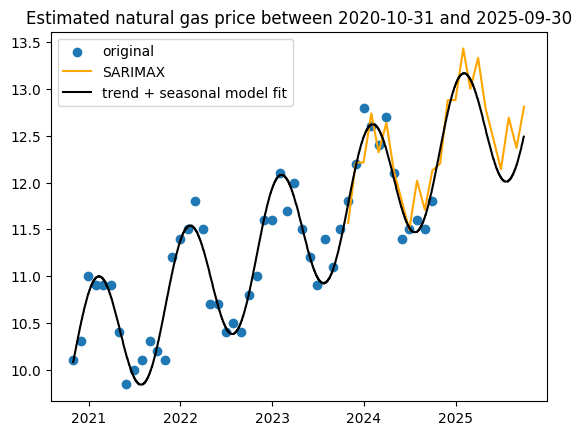

In [19]:
# plot original data, trend+seasonal model fit, and SARIMAX estimation together

Dates = [price.index[36] + relativedelta(months=i) for i in range(24)]
price_pred = pd.DataFrame({"Predictions": predictions_ts}, index=Dates)
plt.scatter(x=price.index, y=price.Prices, label='original')
plt.plot(price_pred.Predictions, color='orange', label='SARIMAX')
plt.plot(df_predictions.Predictions, color='black', label='trend + seasonal model fit')
plt.legend()
plt.title('Estimated natural gas price between 2020-10-31 and 2025-09-30')
plt.show()

From the plot above, we can see that the SARIMAX model tries to maintain every detail of the original data, which is probably why it overfits and has a higher RMSE than the combined trend-seasonal model fit result when we apply them to the test data. The other issue with SARIMAX is that we cannot use it to estimate the price at the daily level for the past and future.

# Prophet

Prophet is an open source package dealing with time series developed by Facebook (Meta), https://facebook.github.io/prophet/docs/installation.html#python. Here I will explore it using simple setups. To have a fair comparison with the other two methods, I will use the first 36 months' data points as the training data and the last 12 months as the test data.

16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing


Prohet's RMSE: 0.635


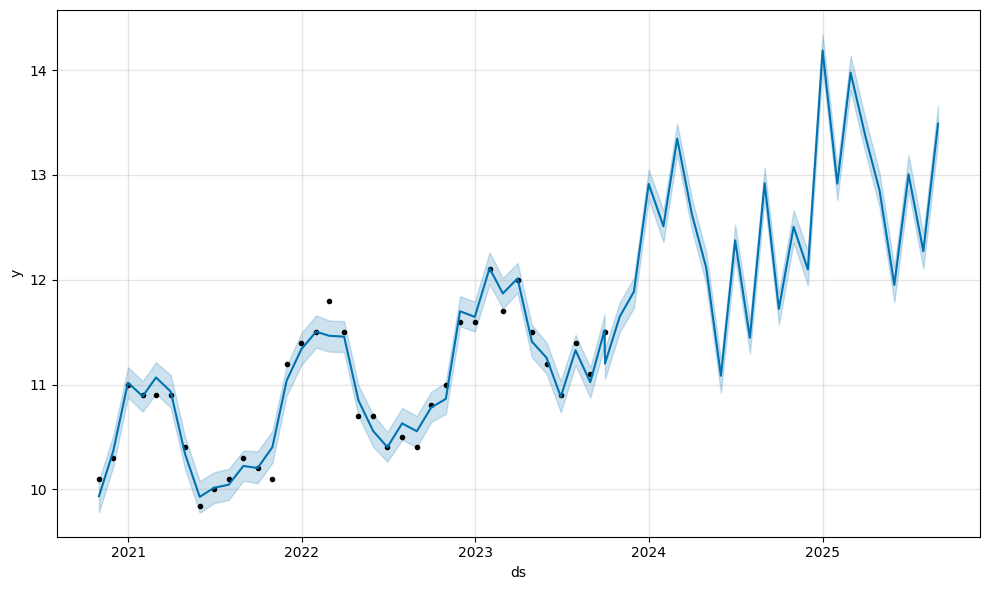

In [20]:
from prophet import Prophet

# use the first 36 months' data as the training set
df_price = price.reset_index().rename(columns={'Dates':'ds', 'Prices':'y'})[0:36]
m = Prophet(seasonality_mode='additive')
m.fit(df_price)
future = m.make_future_dataframe(24, freq='MS')
forecast = m.predict(future)
print(f"Prohet's RMSE: {measure_rmse(test.Prices.values, forecast.yhat.values[36:48])}")
fig = m.plot(forecast)

Both the result and plot above show that with the default setup, Prophet doesn't give as good estimation as the other two methods. Similar to SARIMAX, Prophet can only estimate the price at the monthly level. 

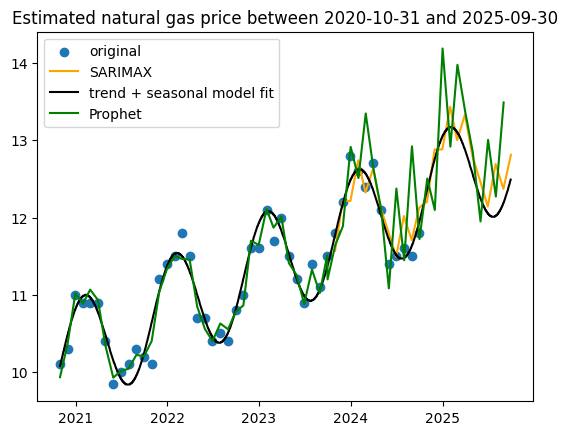

In [21]:
# plot all results together
df_prophet = forecast.loc[:, ['yhat']].copy()
df_prophet['Dates'] = pd.to_datetime(forecast['ds'], format="%Y-%m-%d")
df_prophet = df_prophet.set_index("Dates")
plt.scatter(x=price.index, y=price.Prices, label='original')
plt.plot(price_pred.Predictions, color='orange', label='SARIMAX')
plt.plot(df_predictions.Predictions, color='black', label='trend + seasonal model fit')
plt.plot(df_prophet.yhat, color='green', label='Prophet')
plt.legend()
plt.title('Estimated natural gas price between 2020-10-31 and 2025-09-30')
plt.show()

# Conclusion

In this task, I have explored three different approaches to estimate the price of natural gas in the past and into the future by 12 months using 48 data points at the monthly level. It turns out that if we decompose the time series first and then fit a model for the trend and seasonality components, respectively, the constructed model based on the combination of the trend and seasonal models yield the best results (RMSE=0.186). The SARIMAX model gives similar results (RMSE=0.277) to the first approach. Prophet is the easiest to use, but without careful optimisation, it gives the least accurate results (RMSE=0.635).

At the end, I choose the first model to estimate the daily price of natural gas for dates between 2020-10-31 and 2025-09-30.

In [22]:
def main(any_date):
    from pandas.tseries.holiday import USFederalHolidayCalendar
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start='2020-01-01', end='2025-12-31')
    # if the date is in the original dataset, use the original data
    date = datetime.strptime(any_date, '%Y-%m-%d')
    if date in price.index:
        print(f"The natual gas price for {any_date} is: {price.loc[date].Prices}")
    # check if it is a weekend or holiday
    elif date.weekday() >= 5 or date in holidays:
        print("The input is a weekend or a holiday, so no estimated price is available.")
    else:
        n_days = (date - price.index[0]).days
        estimation = df_predictions.loc[df_predictions.n_days==n_days].Predictions.values[0]
        print(f"The estimated natual gas price for {any_date} is: {estimation}")
if __name__ == '__main__':
    any_date = input("Please input a date between 2020-10-31 and 2025-09-30 in the format of 'YYYY-MM-DD': ")
    date = datetime.strptime(any_date, '%Y-%m-%d')
    while date < df_predictions.index[0] or date > df_predictions.index[-1]:
        any_date = input("The input date is out of range. " +
                "Please input a date between 2020-10-31 and 2025-09-30 in the format of 'YYYY-MM-DD': ")
        date = datetime.strptime(any_date, '%Y-%m-%d')
    main(any_date)

Please input a date between 2020-10-31 and 2025-09-30 in the format of 'YYYY-MM-DD': 2025-09-15
The estimated natual gas price for 2025-09-15 is: 12.33
